<a href="https://colab.research.google.com/github/thanuja-007/webmining-/blob/main/BLOCKCHAIN_THANUJA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Registering Stakeholders:
PharmaCo registered as manufacturer with public key: 145b039eea...
MedDistributors registered as distributor with public key: 8f961d4f6c...
CityPharmacy registered as pharmacy with public key: 143c103859...
Patient_JohnDoe registered as patient with public key: ce971a2a47...

Manufacturing Drug:
Drug D987654 manufactured by PharmaCo

Adding Sensor Data:
Sensor data updated for drug D987654
Sensor data updated for drug D987654

Transferring Drug:
Drug D987654 transferred from PharmaCo to MedDistributors

Adding More Sensor Data:
Sensor data updated for drug D987654

Attempting transfer with bad temperature:
Sensor data updated for drug D987654
Transfer rejected: Temperature 28 exceeds maximum 25

Correcting temperature and retrying transfer:
Sensor data updated for drug D987654
Drug D987654 transferred from MedDistributors to CityPharmacy

Final Transfer to Patient:
Drug D987654 transferred from CityPharmacy to Patient_JohnDoe

Drug Verification Report:
{
  "d

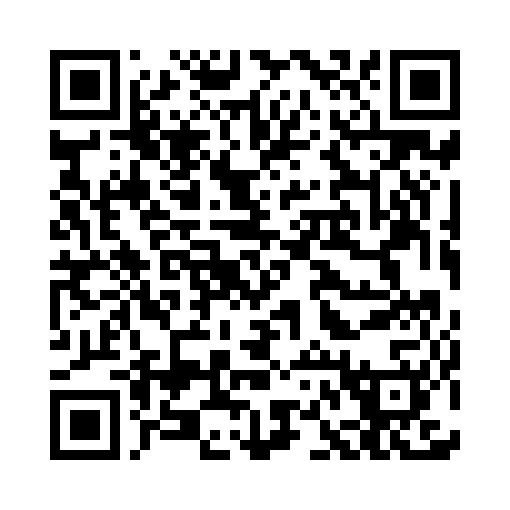


Visualizing Supply Chain:

Supply Chain Visualization for Drug D987654
1. Manufactured from System to PharmaCo
   Timestamp: 2025-06-20 12:18:40.380668
--------------------------------------------------
2. Transfer from PharmaCo to MedDistributors
   Timestamp: 2025-06-20 12:18:40.389266
   Conditions: {'max_temperature': 25}
--------------------------------------------------
3. Transfer from MedDistributors to CityPharmacy
   Timestamp: 2025-06-20 12:18:40.400337
   Conditions: {'max_temperature': 25}
--------------------------------------------------
4. Transfer from CityPharmacy to Patient_JohnDoe
   Timestamp: 2025-06-20 12:18:40.403095
--------------------------------------------------


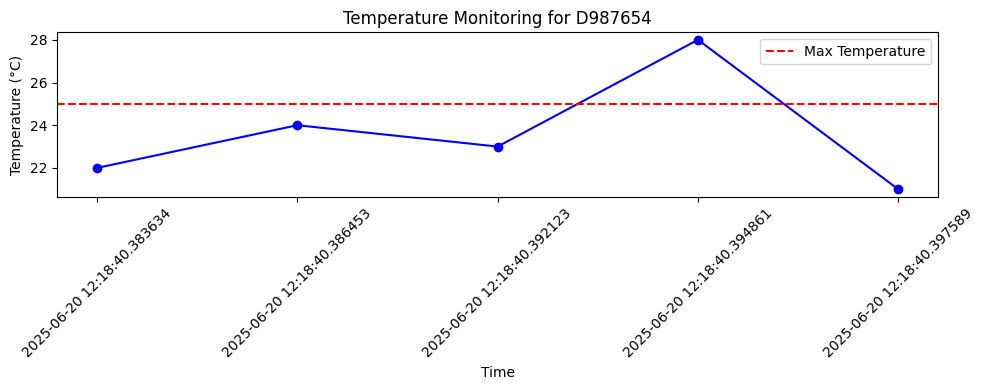

In [ ]:
!pip install qrcode[pil] ecdsa pandas matplotlib
import hashlib
import json
from datetime import datetime
import pandas as pd
from IPython.display import display, Image
import qrcode
import ecdsa
import base64
import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class EnhancedBlock:
    def __init__(self, index, timestamp, data, previous_hash, creator):
        self.index = index
        self.timestamp = timestamp
        self.data = self._sanitize_data(data)
        self.previous_hash = previous_hash
        self.creator = creator
        self.signature = None
        self.hash = self.calculate_hash()

    def _sanitize_data(self, data):
        """Convert non-serializable objects to serializable formats"""
        if isinstance(data, dict):
            return {k: self._sanitize_data(v) for k, v in data.items()}
        elif isinstance(data, (list, tuple)):
            return [self._sanitize_data(item) for item in data]
        elif hasattr(data, '__dict__'):
            return self._sanitize_data(data.__dict__)
        elif isinstance(data, (str, int, float, bool)) or data is None:
            return data
        else:
            return str(data)

    def calculate_hash(self):
        block_string = json.dumps({
            "index": self.index,
            "timestamp": str(self.timestamp),
            "data": self.data,
            "previous_hash": self.previous_hash,
            "creator": self.creator
        }, sort_keys=True).encode()
        return hashlib.sha256(block_string).hexdigest()

    def sign_block(self, private_key):
        sk = ecdsa.SigningKey.from_string(bytes.fromhex(private_key), curve=ecdsa.SECP256k1)
        message = json.dumps(self.__dict__, sort_keys=True, default=str).encode()
        self.signature = base64.b64encode(sk.sign(message)).decode('utf-8')

    def verify_signature(self, public_key):
        if not self.signature:
            return False
        vk = ecdsa.VerifyingKey.from_string(bytes.fromhex(public_key), curve=ecdsa.SECP256k1)
        try:
            message = json.dumps(self.__dict__, sort_keys=True, default=str).encode()
            return vk.verify(base64.b64decode(self.signature), message)
        except:
            return False

class Drug:
    def __init__(self, drug_id, drug_name, manufacturer, details):
        self.drug_id = drug_id
        self.drug_name = drug_name
        self.manufacturer = manufacturer
        self.current_holder = manufacturer
        self.manufacture_date = str(datetime.now())
        self.details = details
        self.qr_code = self._generate_qr_code()
        self.transaction_history = [{
            "from": "System",
            "to": manufacturer,
            "timestamp": str(datetime.now()),
            "action": "Manufactured",
            "signed_by": manufacturer}]
        self.temperature_log = []
        self.location_log = []

    def _generate_qr_code(self):
        """Generate QR code and return as base64 encoded string"""
        qr = qrcode.QRCode(version=1, box_size=10, border=5)
        qr_data = {
            "drug_id": self.drug_id,
            "manufacturer": self.manufacturer,
            "timestamp": self.manufacture_date
        }
        qr.add_data(json.dumps(qr_data))
        qr.make(fit=True)

        img = qr.make_image(fill_color="black", back_color="white")
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')

    def display_qr_code(self):
        """Display the QR code in notebook"""
        display(Image(base64.b64decode(self.qr_code)))

    def add_transaction(self, from_entity, to_entity, action, conditions=None, signed_by=None):
        self.transaction_history.append({
            "from": from_entity,
            "to": to_entity,
            "timestamp": str(datetime.now()),
            "action": action,
            "conditions": conditions,
            "signed_by": signed_by or from_entity
        })
        self.current_holder = to_entity

    def add_sensor_data(self, temperature=None, location=None, by_entity=None):
        if temperature is not None:
            self.temperature_log.append({
                "temperature": temperature,
                "timestamp": str(datetime.now()),
                "recorded_by": by_entity
            })

        if location is not None:
            self.location_log.append({
                "location": location,
                "timestamp": str(datetime.now()),
                "recorded_by": by_entity
            })

class StakeholderManager:
    def __init__(self):
        self.stakeholders = {
            "manufacturer": {},
            "distributor": {},
            "pharmacy": {},
            "patient": {}
        }
        self.private_keys = {}
        self.public_keys = {}

    def generate_key_pair(self, entity):
        sk = ecdsa.SigningKey.generate(curve=ecdsa.SECP256k1)
        vk = sk.get_verifying_key()
        self.private_keys[entity] = sk.to_string().hex()
        self.public_keys[entity] = vk.to_string().hex()
        return self.public_keys[entity]

    def register_stakeholder(self, name, role, location=None, license=None):
        if role not in self.stakeholders:
            return False, "Invalid role"

        if name in [entity for entities in self.stakeholders.values() for entity in entities]:
            return False, "Entity already registered"

        pub_key = self.generate_key_pair(name)
        self.stakeholders[role][name] = {
            "public_key": pub_key,
            "location": location,
            "license": license,
            "registration_date": str(datetime.now())
        }
        return True, f"{name} registered as {role} with public key: {pub_key[:10]}..."

    def get_public_key(self, entity):
        for role in self.stakeholders:
            if entity in self.stakeholders[role]:
                return self.stakeholders[role][entity]["public_key"]
        return None

    def verify_role(self, entity, role):
        return role in self.stakeholders and entity in self.stakeholders[role]

    def get_stakeholder_info(self, entity):
        for role in self.stakeholders:
            if entity in self.stakeholders[role]:
                return {
                    "role": role,
                    "details": self.stakeholders[role][entity]
                }
        return None

class EnhancedDrugBlockchain:
    def __init__(self):
        self.chain = [self.create_genesis_block()]
        self.drugs = {}
        self.stakeholder_manager = StakeholderManager()

    def create_genesis_block(self):
        return EnhancedBlock(0, datetime.now(), "Genesis Block", "0", "System")

    def register_stakeholder(self, name, role, location=None, license=None):
        return self.stakeholder_manager.register_stakeholder(name, role, location, license)

    def manufacture_drug(self, drug_id, drug_name, manufacturer, details):
        if not self.stakeholder_manager.verify_role(manufacturer, "manufacturer"):
            return False, "Only registered manufacturers can create drugs"

        if drug_id in self.drugs:
            return False, "Drug ID already exists"

        self.drugs[drug_id] = Drug(drug_id, drug_name, manufacturer, details)

        # Create and sign block
        new_block = EnhancedBlock(
            len(self.chain),
            datetime.now(),
            {
                "action": "manufacture",
                "drug_id": drug_id,
                "drug_name": drug_name,
                "manufacturer": manufacturer,
                "details": details
            },
            self.get_latest_block().hash,
            manufacturer
        )
        new_block.sign_block(self.stakeholder_manager.private_keys[manufacturer])
        self.add_block(new_block)

        return True, f"Drug {drug_id} manufactured by {manufacturer}"

    def add_sensor_data(self, drug_id, temperature=None, location=None, by_entity=None):
        if drug_id not in self.drugs:
            return False, "Drug not found"

        # Verify by_entity is current holder
        if by_entity != self.drugs[drug_id].current_holder:
            return False, f"{by_entity} is not the current holder"

        self.drugs[drug_id].add_sensor_data(temperature, location, by_entity)

        # Create and sign block
        new_block = EnhancedBlock(
            len(self.chain),
            datetime.now(),
            {
                "action": "sensor_update",
                "drug_id": drug_id,
                "temperature": temperature,
                "location": location
            },
            self.get_latest_block().hash,
            by_entity
        )
        new_block.sign_block(self.stakeholder_manager.private_keys[by_entity])
        self.add_block(new_block)

        return True, f"Sensor data updated for drug {drug_id}"

    def transfer_drug(self, drug_id, from_entity, to_entity, to_role, conditions=None):
        if drug_id not in self.drugs:
            return False, "Drug not found"

        drug = self.drugs[drug_id]

        if drug.current_holder != from_entity:
            return False, f"{from_entity} is not the current holder"

        if not self.stakeholder_manager.verify_role(to_entity, to_role):
            return False, f"Invalid recipient or role"

        # Verify temperature conditions
        if conditions and "max_temperature" in conditions:
            if drug.temperature_log:
                last_temp = drug.temperature_log[-1]["temperature"]
                if last_temp > conditions["max_temperature"]:
                    return False, f"Transfer rejected: Temperature {last_temp} exceeds maximum {conditions['max_temperature']}"

        # Perform transfer
        drug.add_transaction(from_entity, to_entity, "Transfer", conditions, from_entity)

        # Create and sign block
        new_block = EnhancedBlock(
            len(self.chain),
            datetime.now(),
            {
                "action": "transfer",
                "drug_id": drug_id,
                "from": from_entity,
                "to": to_entity,
                "role": to_role,
                "conditions": conditions
            },
            self.get_latest_block().hash,
            from_entity
        )
        new_block.sign_block(self.stakeholder_manager.private_keys[from_entity])
        self.add_block(new_block)

        return True, f"Drug {drug_id} transferred from {from_entity} to {to_entity}"

    def get_latest_block(self):
        return self.chain[-1]

    def add_block(self, new_block):
        if not new_block.verify_signature(self.stakeholder_manager.get_public_key(new_block.creator)):
            return False, "Invalid signature - block rejected"

        new_block.previous_hash = self.get_latest_block().hash
        new_block.hash = new_block.calculate_hash()
        self.chain.append(new_block)
        return True, "Block added successfully"

    def verify_drug(self, drug_id, verify_chain=True):
        if drug_id not in self.drugs:
            return {"status": "error", "message": "Drug not found"}

        drug = self.drugs[drug_id]
        drug_info = {
            "drug_id": drug.drug_id,
            "drug_name": drug.drug_name,
            "manufacturer": drug.manufacturer,
            "current_holder": drug.current_holder,
            "manufacture_date": drug.manufacture_date,
            "details": drug.details,
            "transaction_history": drug.transaction_history,
            "temperature_log": drug.temperature_log,
            "location_log": drug.location_log
        }

        # Verify blockchain consistency
        drug_info["blockchain_valid"] = self.is_chain_valid() if verify_chain else "Not verified"

        # Check for counterfeit indicators
        risk_factors = 0

        # 1. Check if all transfers were properly signed
        for tx in drug.transaction_history:
            if "signed_by" not in tx:
                risk_factors += 1

        # 2. Check temperature violations
        temp_violations = sum(1 for t in drug.temperature_log
                            if "max_temperature" in drug.details
                            and t["temperature"] > drug.details["max_temperature"])

        # 3. Check for unexpected holders
        valid_holders = set()
        for role in self.stakeholder_manager.stakeholders:
            valid_holders.update(self.stakeholder_manager.stakeholders[role].keys())

        for tx in drug.transaction_history:
            if tx["to"] not in valid_holders:
                risk_factors += 1

        # Calculate risk score
        risk_score = min(100, (risk_factors * 30) + (temp_violations * 20))

        if risk_score > 70:
            drug_info["counterfeit_risk"] = "High"
        elif risk_score > 30:
            drug_info["counterfeit_risk"] = "Medium"
        else:
            drug_info["counterfeit_risk"] = "Low"

        drug_info["risk_score"] = risk_score
        drug_info["risk_factors"] = risk_factors
        drug_info["temp_violations"] = temp_violations

        return drug_info

    def is_chain_valid(self):
        for i in range(1, len(self.chain)):
            current_block = self.chain[i]
            previous_block = self.chain[i-1]
            # Check hash integrity
            if current_block.hash != current_block.calculate_hash():
                return False

            # Check block linkage
            if current_block.previous_hash != previous_block.hash:
                return False

            # Verify signatures
            if not current_block.verify_signature(self.stakeholder_manager.get_public_key(current_block.creator)):
                return False

        return True

    def visualize_supply_chain(self, drug_id):
        if drug_id not in self.drugs:
            print("Drug not found")
            return

        drug = self.drugs[drug_id]

        print(f"\nSupply Chain Visualization for Drug {drug_id}")
        print("="*50)

        for i, tx in enumerate(drug.transaction_history):
            print(f"{i+1}. {tx['action']} from {tx.get('from', 'System')} to {tx['to']}")
            print(f"   Timestamp: {tx['timestamp']}")
            if 'conditions' in tx and tx['conditions']:
                print(f"   Conditions: {tx['conditions']}")
            print("-"*50)

        # Plot temperature log if available
        if drug.temperature_log:
            temps = [x["temperature"] for x in drug.temperature_log]
            times = [x["timestamp"] for x in drug.temperature_log]

            plt.figure(figsize=(10, 4))
            plt.plot(times, temps, 'b-o')
            if "max_temperature" in drug.details:
                plt.axhline(y=drug.details["max_temperature"], color='r', linestyle='--',
                           label='Max Temperature')
            plt.title(f"Temperature Monitoring for {drug_id}")
            plt.xlabel("Time")
            plt.ylabel("Temperature (°C)")
            plt.xticks(rotation=45)
            plt.legend()
            plt.tight_layout()
            plt.show()

    def display_qr_code(self, drug_id):
        if drug_id not in self.drugs:
            print("Drug not found")
            return

        print(f"\nQR Code for Drug {drug_id}")
        self.drugs[drug_id].display_qr_code()

    def display_blockchain(self):
        chain_data = []
        for block in self.chain:
            # Handle genesis block which has string data
            if isinstance(block.data, str):
                action = "GENESIS"
                drug_id = "N/A"
            else:
                action = block.data.get("action", "N/A")
                drug_id = block.data.get("drug_id", "N/A")

            chain_data.append({
                "Index": block.index,
                "Timestamp": str(block.timestamp),
                "Creator": block.creator,
                "Action": action,
                "Drug ID": drug_id,
                "Previous Hash": block.previous_hash[:10] + "...",
                "Hash": block.hash[:10] + "...",
                "Signature Valid": block.verify_signature(self.stakeholder_manager.get_public_key(block.creator))
            })
        return pd.DataFrame(chain_data)

# Demo Execution
def run_demo():
    # Initialize the enhanced blockchain
    blockchain = EnhancedDrugBlockchain()

    # Register stakeholders with more details
    print("\nRegistering Stakeholders:")
    print(blockchain.register_stakeholder(
        "PharmaCo",
        "manufacturer",
        location="123 Pharma St, Boston, MA",
        license="US-MFG-2023-12345"
    )[1])

    print(blockchain.register_stakeholder(
        "MedDistributors",
        "distributor",
        location="456 Distribution Ave, Chicago, IL",
        license="US-DIST-2022-67890"
    )[1])

    print(blockchain.register_stakeholder(
        "CityPharmacy",
        "pharmacy",
        location="789 Main St, New York, NY",
        license="US-PHARM-2023-54321"
    )[1])

    print(blockchain.register_stakeholder(
        "Patient_JohnDoe",
        "patient"
    )[1])

    # Manufacture a drug with detailed specifications
    print("\nManufacturing Drug:")
    print(blockchain.manufacture_drug(
        drug_id="D987654",
        drug_name="Antibiotic XR 750mg",
        manufacturer="PharmaCo",
        details={
            "composition": "Amoxicillin 750mg",
            "max_temperature": 25,  # Celsius
            "storage_conditions": "Dry, below 25°C",
            "batch_no": "B20230615",
            "expiry_date": "2025-12-31",
            "serial_no": "SN123456789"
        }
    )[1])

    # Simulate temperature monitoring during distribution
    print("\nAdding Sensor Data:")
    print(blockchain.add_sensor_data(
        drug_id="D987654",
        temperature=22,
        by_entity="PharmaCo"
    )[1])

    print(blockchain.add_sensor_data(
        drug_id="D987654",
        temperature=24,
        location="Boston Warehouse",
        by_entity="PharmaCo"
    )[1])

    # Transfer with temperature condition
    print("\nTransferring Drug:")
    print(blockchain.transfer_drug(
        drug_id="D987654",
        from_entity="PharmaCo",
        to_entity="MedDistributors",
        to_role="distributor",
        conditions={"max_temperature": 25}
    )[1])

    # Simulate transportation with temperature changes
    print("\nAdding More Sensor Data:")
    print(blockchain.add_sensor_data(
        drug_id="D987654",
        temperature=23,
        location="In transit to Chicago",
        by_entity="MedDistributors"
    )[1])

    # Attempt a transfer that would violate conditions (should fail)
    print("\nAttempting transfer with bad temperature:")
    print(blockchain.add_sensor_data(
        drug_id="D987654",
        temperature=28,  # Above max temperature
        location="Chicago Warehouse",
        by_entity="MedDistributors"
    )[1])

    print(blockchain.transfer_drug(
        drug_id="D987654",
        from_entity="MedDistributors",
        to_entity="CityPharmacy",
        to_role="pharmacy",
        conditions={"max_temperature": 25}
    )[1])

    # Fix the temperature and complete transfer
    print("\nCorrecting temperature and retrying transfer:")
    print(blockchain.add_sensor_data(
        drug_id="D987654",
        temperature=21,  # Fixed temperature
        location="Chicago Warehouse - Cold Storage",
        by_entity="MedDistributors"
    )[1])

    print(blockchain.transfer_drug(
        drug_id="D987654",
        from_entity="MedDistributors",
        to_entity="CityPharmacy",
        to_role="pharmacy",
        conditions={"max_temperature": 25}
    )[1])

    # Final transfer to patient
    print("\nFinal Transfer to Patient:")
    print(blockchain.transfer_drug(
        drug_id="D987654",
        from_entity="CityPharmacy",
        to_entity="Patient_JohnDoe",
        to_role="patient"
    )[1])

    # Verify the drug
    print("\nDrug Verification Report:")
    verification = blockchain.verify_drug("D987654")
    print(json.dumps(verification, indent=2))

    # Display QR code
    print("\nDisplaying QR Code:")
    blockchain.display_qr_code("D987654")

    # Visualize supply chain
    print("\nVisualizing Supply Chain:")
    blockchain.visualize_supply_chain("D987654")

    ##

# Run the demo
if __name__ == "__main__":
    run_demo()